In [2]:
import numpy as np
import os
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional
from tensorflow.keras.layers import SimpleRNN, GRU
from tensorflow.keras.layers import Dropout, InputLayer, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

import warnings
warnings.filterwarnings(action='ignore')

#한글설정
import matplotlib.font_manager as fm

font_dirs = ['/usr/share/fonts/truetype/nanum', ]
font_files = fm.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    fm.fontManager.addfont(font_file)
    
# 한글 출력을 위해서 폰트 옵션을 설정합니다.
# "axes.unicode_minus" : 마이너스가 깨질 것을 방지

sns.set(font="NanumBarunGothic",
        rc={"axes.unicode_minus":False},
        style='darkgrid')

#GPU 사용 설정, -1이면 CPU 사용
# os.environ["CUDA_VISIBLE_DEVICES"] = "0, 1"

gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
    try:
        for i in range(len(gpus)):
            tf.config.experimental.set_memory_growth(gpus[i], True)
    except RuntimeError as e:
        # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
        print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


# 시계열, LSTM

In [3]:
# 2. LSTM model
def get_model():
    lstm = Sequential()
    lstm.add(InputLayer(input_shape=(x.shape[1],x.shape[2])))
    lstm.add(LSTM(units=128, activation='hard_sigmoid', return_sequences=True))
    lstm.add(LSTM(units=64, activation='hard_sigmoid', return_sequences=True))
    lstm.add(Dropout(0.2))
    lstm.add(LSTM(units=64, activation='hard_sigmoid', return_sequences=True))
    lstm.add(LSTM(units=32, activation='hard_sigmoid', return_sequences=False))
    lstm.add(Dropout(0.2))
    lstm.add(Dense(units=1, activation='sigmoid'))

    lstm.compile(optimizer= keras.optimizers.Adam(learning_rate = 0.001), 
                 loss = "binary_crossentropy", metrics=['acc'])
    return lstm


path = '/project/LSH/'
with tf.device('/device:GPU:0'):
    # 1. Data load
    x = np.load(path + 'x_(7727,10,4068).npy')
    y = np.load(path + 'y_(7727,1).npy')

    acc_list, precision_list, recall_list, f1_list, auc_list = [], [], [], [], []
    sss = StratifiedShuffleSplit(n_splits=10, test_size = 0.2, random_state = 42)

    # 4. Crossvalidation
    for seed, (train_index, test_index) in tqdm(enumerate(sss.split(x, y))):
        X_train, y_train = x[train_index,:,:], y[train_index]
        X_test, y_test = x[test_index,:,:], y[test_index]
        
        early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

        model = get_model()
        model.fit(X_train, y_train, epochs=300, batch_size=516, validation_split=0.25, callbacks=[early_stop])

        y_pred_test = model.predict(X_test)

        y_pred_test[y_pred_test>0.5]=1
        y_pred_test[y_pred_test<=0.5]=0
        precision = precision_score(y_test, y_pred_test)
        recall = recall_score(y_test, y_pred_test)
        f1 = f1_score(y_test, y_pred_test)
        roc_auc = roc_auc_score(y_test, y_pred_test)
        acc = accuracy_score(y_test, y_pred_test)
        
        acc_list.append(acc)
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)
        auc_list.append(roc_auc)
        
    print(f'정확도 : {np.mean(acc_list)}, Precision : {np.mean(precision_list)}, Recall : {np.mean(recall_list)}, F1 : {np.mean(f1_list)}, roc_auc : {np.mean(auc_list)}')
    

0it [00:00, ?it/s]

Epoch 1/300
9/9 [==============================] - 5s 153ms/step - loss: 0.8916 - acc: 0.3881 - val_loss: 0.7479 - val_acc: 0.3946
Epoch 2/300
9/9 [==============================] - 1s 90ms/step - loss: 0.7040 - acc: 0.5165 - val_loss: 0.6718 - val_acc: 0.6054
Epoch 3/300
9/9 [==============================] - 1s 90ms/step - loss: 0.6762 - acc: 0.6106 - val_loss: 0.6815 - val_acc: 0.6054
Epoch 4/300
9/9 [==============================] - 1s 89ms/step - loss: 0.6856 - acc: 0.6037 - val_loss: 0.6726 - val_acc: 0.6054
Epoch 5/300
9/9 [==============================] - 1s 89ms/step - loss: 0.6750 - acc: 0.5994 - val_loss: 0.6706 - val_acc: 0.6054
Epoch 6/300
9/9 [==============================] - 1s 90ms/step - loss: 0.6744 - acc: 0.5996 - val_loss: 0.6708 - val_acc: 0.6054
Epoch 7/300
9/9 [==============================] - 1s 90ms/step - loss: 0.6745 - acc: 0.5914 - val_loss: 0.6704 - val_acc: 0.6054
Epoch 8/300
9/9 [==============================] - 1s 91ms/step - loss: 0.6725 - acc: 0.6

9/9 [==============================] - 1s 88ms/step - loss: 0.3146 - acc: 0.8891 - val_loss: 0.5549 - val_acc: 0.7613
Epoch 23/300
9/9 [==============================] - 1s 89ms/step - loss: 0.3117 - acc: 0.8895 - val_loss: 0.5514 - val_acc: 0.7755
Epoch 24/300
9/9 [==============================] - 1s 87ms/step - loss: 0.2953 - acc: 0.8988 - val_loss: 0.5747 - val_acc: 0.7697
Epoch 25/300
9/9 [==============================] - 1s 88ms/step - loss: 0.2907 - acc: 0.8988 - val_loss: 0.5859 - val_acc: 0.7665
Epoch 26/300
9/9 [==============================] - 1s 89ms/step - loss: 0.2661 - acc: 0.9115 - val_loss: 0.5700 - val_acc: 0.7762
Epoch 00026: early stopping
Epoch 1/300
9/9 [==============================] - 5s 147ms/step - loss: 0.6745 - acc: 0.6030 - val_loss: 0.6663 - val_acc: 0.6171
Epoch 2/300
9/9 [==============================] - 1s 86ms/step - loss: 0.6741 - acc: 0.6060 - val_loss: 0.6653 - val_acc: 0.6171
Epoch 3/300
9/9 [==============================] - 1s 90ms/step - los

Epoch 1/300
9/9 [==============================] - 5s 146ms/step - loss: 0.6883 - acc: 0.6201 - val_loss: 0.6816 - val_acc: 0.5796
Epoch 2/300
9/9 [==============================] - 1s 88ms/step - loss: 0.6729 - acc: 0.6073 - val_loss: 0.6804 - val_acc: 0.5796
Epoch 3/300
9/9 [==============================] - 1s 89ms/step - loss: 0.6676 - acc: 0.6186 - val_loss: 0.6860 - val_acc: 0.5796
Epoch 4/300
9/9 [==============================] - 1s 90ms/step - loss: 0.6704 - acc: 0.6211 - val_loss: 0.6861 - val_acc: 0.5796
Epoch 5/300
9/9 [==============================] - 1s 89ms/step - loss: 0.6681 - acc: 0.6196 - val_loss: 0.6824 - val_acc: 0.5796
Epoch 6/300
9/9 [==============================] - 1s 91ms/step - loss: 0.6668 - acc: 0.6205 - val_loss: 0.6798 - val_acc: 0.5796
Epoch 7/300
9/9 [==============================] - 1s 87ms/step - loss: 0.6630 - acc: 0.6209 - val_loss: 0.6777 - val_acc: 0.5796
Epoch 8/300
9/9 [==============================] - 1s 90ms/step - loss: 0.6586 - acc: 0.6

9/9 [==============================] - 5s 144ms/step - loss: 0.6890 - acc: 0.5493 - val_loss: 0.6794 - val_acc: 0.5964
Epoch 2/300
9/9 [==============================] - 1s 88ms/step - loss: 0.6750 - acc: 0.6117 - val_loss: 0.6775 - val_acc: 0.5964
Epoch 3/300
9/9 [==============================] - 1s 87ms/step - loss: 0.6699 - acc: 0.6110 - val_loss: 0.6742 - val_acc: 0.5964
Epoch 4/300
9/9 [==============================] - 1s 89ms/step - loss: 0.6696 - acc: 0.6121 - val_loss: 0.6741 - val_acc: 0.5964
Epoch 5/300
9/9 [==============================] - 1s 84ms/step - loss: 0.6723 - acc: 0.6088 - val_loss: 0.6744 - val_acc: 0.5964
Epoch 6/300
9/9 [==============================] - 1s 89ms/step - loss: 0.6692 - acc: 0.6121 - val_loss: 0.6731 - val_acc: 0.5964
Epoch 7/300
9/9 [==============================] - 1s 89ms/step - loss: 0.6695 - acc: 0.6112 - val_loss: 0.6688 - val_acc: 0.5964
Epoch 8/300
9/9 [==============================] - 1s 87ms/step - loss: 0.6619 - acc: 0.6151 - val_lo

9/9 [==============================] - 1s 88ms/step - loss: 0.6766 - acc: 0.5935 - val_loss: 0.6624 - val_acc: 0.6229
Epoch 3/300
9/9 [==============================] - 1s 90ms/step - loss: 0.6766 - acc: 0.6054 - val_loss: 0.6626 - val_acc: 0.6229
Epoch 4/300
9/9 [==============================] - 1s 89ms/step - loss: 0.6763 - acc: 0.6006 - val_loss: 0.6631 - val_acc: 0.6229
Epoch 5/300
9/9 [==============================] - 1s 87ms/step - loss: 0.6722 - acc: 0.6063 - val_loss: 0.6608 - val_acc: 0.6229
Epoch 6/300
9/9 [==============================] - 1s 88ms/step - loss: 0.6686 - acc: 0.6086 - val_loss: 0.6532 - val_acc: 0.6229
Epoch 7/300
9/9 [==============================] - 1s 90ms/step - loss: 0.6565 - acc: 0.6069 - val_loss: 0.6332 - val_acc: 0.6229
Epoch 8/300
9/9 [==============================] - 1s 88ms/step - loss: 0.6256 - acc: 0.6347 - val_loss: 0.5888 - val_acc: 0.7238
Epoch 9/300
9/9 [==============================] - 1s 88ms/step - loss: 0.5705 - acc: 0.7204 - val_los

정확도 : 0.7626778783958603, Precision : 0.8146078717974209, Recall : 0.7922669491525424, F1 : 0.8028529765175854, roc_auc : 0.7542730094599921



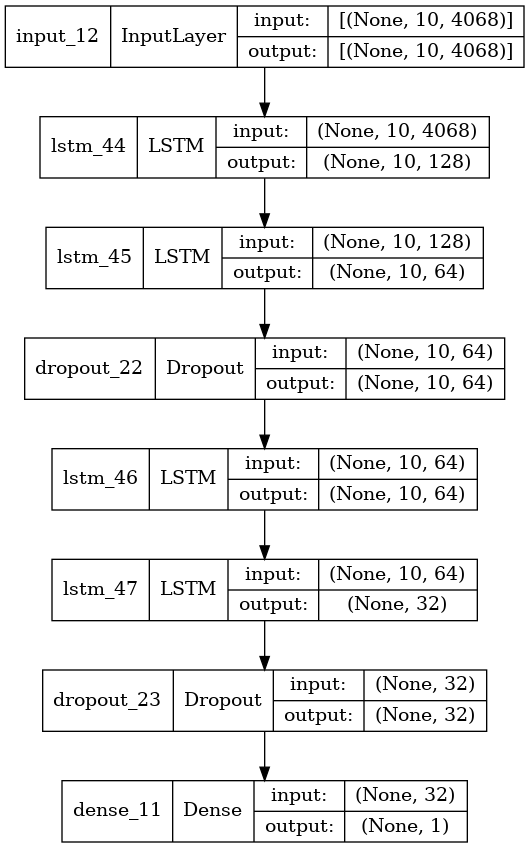

In [5]:
lstm = get_model()
tf.keras.utils.plot_model(lstm, show_shapes=True)

In [6]:
lstm.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_44 (LSTM)              (None, 10, 128)           2148864   
                                                                 
 lstm_45 (LSTM)              (None, 10, 64)            49408     
                                                                 
 dropout_22 (Dropout)        (None, 10, 64)            0         
                                                                 
 lstm_46 (LSTM)              (None, 10, 64)            33024     
                                                                 
 lstm_47 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_23 (Dropout)        (None, 32)                0         
                                                                 
 dense_11 (Dense)            (None, 1)               

In [12]:
#lstm과 구조 동일하게
def rnn_model(X_train):    
    rnn = Sequential()
    rnn.add(InputLayer(input_shape=(X_train.shape[1],X_train.shape[2])))
    rnn.add(SimpleRNN(units=128, activation='hard_sigmoid', return_sequences=True))
    rnn.add(SimpleRNN(units=64, activation='hard_sigmoid', return_sequences=True))
    rnn.add(Dropout(0.2))
    rnn.add(SimpleRNN(units=64, activation='hard_sigmoid', return_sequences=True))
    rnn.add(SimpleRNN(units=32, activation='hard_sigmoid', return_sequences=False))
    rnn.add(Dropout(0.2))
    rnn.add(Dense(units=1, activation='sigmoid'))
    rnn.compile(optimizer= keras.optimizers.Adam(learning_rate = 0.001), 
                 loss = "binary_crossentropy", metrics=['acc'])
    return rnn

def gru_model(X_train):
    gru = Sequential()
    gru.add(InputLayer(input_shape=(X_train.shape[1],X_train.shape[2])))
    gru.add(GRU(units=128, activation='hard_sigmoid', return_sequences=True))
    gru.add(GRU(units=64, activation='hard_sigmoid', return_sequences=True))
    gru.add(Dropout(0.2))
    gru.add(GRU(units=64, activation='hard_sigmoid', return_sequences=True))
    gru.add(GRU(units=32, activation='hard_sigmoid', return_sequences=False))
    gru.add(Dropout(0.2))
    gru.add(Dense(units=1, activation='sigmoid'))
    gru.compile(optimizer= keras.optimizers.Adam(learning_rate = 0.001), 
                 loss = "binary_crossentropy", metrics=['acc'])
    return gru

In [28]:
def time_series_cv(name):
    path = '/project/LSH/'
    with tf.device('/device:GPU:0'):
        # 1. Data load
        x = np.load(path + 'x_(7727,10,4068).npy')
        y = np.load(path + 'y_(7727,1).npy')

        acc_list, precision_list, recall_list, f1_list, auc_list = [], [], [], [], []
        sss = StratifiedShuffleSplit(n_splits=10, test_size = 0.2, random_state = 42)

        # 4. Crossvalidation
        for seed, (train_index, test_index) in tqdm(enumerate(sss.split(x, y))):
            X_train, y_train = x[train_index,:,:], y[train_index]
            X_test, y_test = x[test_index,:,:], y[test_index]
            
            early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)

            if name == 'LSTM':
                model = get_model()
            elif name == 'RNN':
                model = rnn_model(X_train)
            elif name == 'GRU':
                model = gru_model(X_train)
                
            model.fit(X_train, y_train, epochs=300, batch_size=516, validation_split=0.25, callbacks=[early_stop])

            y_pred_test = model.predict(X_test)

            y_pred_test[y_pred_test>0.5]=1
            y_pred_test[y_pred_test<=0.5]=0

            precision = precision_score(y_test, y_pred_test)
            recall = recall_score(y_test, y_pred_test)
            f1 = f1_score(y_test, y_pred_test)
            roc_auc = roc_auc_score(y_test, y_pred_test)
            acc = accuracy_score(y_test, y_pred_test)

            acc_list.append(acc)
            precision_list.append(precision)
            recall_list.append(recall)
            f1_list.append(f1)
            auc_list.append(roc_auc)

        print(f'{name} 정확도 : {np.mean(acc_list)}, Precision : {np.mean(precision_list)}, Recall : {np.mean(recall_list)}, F1 : {np.mean(f1_list)}, roc_auc : {np.mean(auc_list)}')   
    return acc_list, precision_list, recall_list, f1_list, auc_list



In [29]:
time_series_cv('LSTM')

0it [00:00, ?it/s]

Epoch 1/300
9/9 [==============================] - 5s 157ms/step - loss: 0.7008 - acc: 0.5169 - val_loss: 0.6708 - val_acc: 0.6054
Epoch 2/300
9/9 [==============================] - 1s 93ms/step - loss: 0.6778 - acc: 0.6140 - val_loss: 0.6746 - val_acc: 0.6054
Epoch 3/300
9/9 [==============================] - 1s 92ms/step - loss: 0.6720 - acc: 0.6106 - val_loss: 0.6705 - val_acc: 0.6054
Epoch 4/300
9/9 [==============================] - 1s 90ms/step - loss: 0.6734 - acc: 0.6030 - val_loss: 0.6703 - val_acc: 0.6054
Epoch 5/300
9/9 [==============================] - 1s 93ms/step - loss: 0.6705 - acc: 0.6086 - val_loss: 0.6697 - val_acc: 0.6054
Epoch 6/300
9/9 [==============================] - 1s 92ms/step - loss: 0.6714 - acc: 0.6078 - val_loss: 0.6687 - val_acc: 0.6054
Epoch 7/300
9/9 [==============================] - 1s 95ms/step - loss: 0.6691 - acc: 0.6119 - val_loss: 0.6664 - val_acc: 0.6054
Epoch 8/300
9/9 [==============================] - 1s 93ms/step - loss: 0.6655 - acc: 0.6

9/9 [==============================] - 1s 93ms/step - loss: 0.2854 - acc: 0.9016 - val_loss: 0.5732 - val_acc: 0.7633
Epoch 20/300
9/9 [==============================] - 1s 93ms/step - loss: 0.2703 - acc: 0.9122 - val_loss: 0.5925 - val_acc: 0.7620
Epoch 21/300
9/9 [==============================] - 1s 91ms/step - loss: 0.2544 - acc: 0.9143 - val_loss: 0.6055 - val_acc: 0.7684
Epoch 22/300
9/9 [==============================] - 1s 91ms/step - loss: 0.2388 - acc: 0.9225 - val_loss: 0.6232 - val_acc: 0.7639
Epoch 23/300
9/9 [==============================] - 1s 91ms/step - loss: 0.2264 - acc: 0.9327 - val_loss: 0.6479 - val_acc: 0.7574
Epoch 24/300
9/9 [==============================] - 1s 90ms/step - loss: 0.2162 - acc: 0.9329 - val_loss: 0.6613 - val_acc: 0.7607
Epoch 25/300
9/9 [==============================] - 1s 90ms/step - loss: 0.2141 - acc: 0.9331 - val_loss: 0.6967 - val_acc: 0.7587
Epoch 26/300
9/9 [==============================] - 1s 90ms/step - loss: 0.2243 - acc: 0.9279 - 

9/9 [==============================] - 1s 91ms/step - loss: 0.6780 - acc: 0.5916 - val_loss: 0.6608 - val_acc: 0.6274
Epoch 5/300
9/9 [==============================] - 1s 92ms/step - loss: 0.6804 - acc: 0.5946 - val_loss: 0.6592 - val_acc: 0.6274
Epoch 6/300
9/9 [==============================] - 1s 91ms/step - loss: 0.6702 - acc: 0.6024 - val_loss: 0.6583 - val_acc: 0.6274
Epoch 7/300
9/9 [==============================] - 1s 93ms/step - loss: 0.6732 - acc: 0.6004 - val_loss: 0.6528 - val_acc: 0.6274
Epoch 8/300
9/9 [==============================] - 1s 89ms/step - loss: 0.6644 - acc: 0.6052 - val_loss: 0.6405 - val_acc: 0.6274
Epoch 9/300
9/9 [==============================] - 1s 88ms/step - loss: 0.6414 - acc: 0.6194 - val_loss: 0.6166 - val_acc: 0.6274
Epoch 10/300
9/9 [==============================] - 1s 140ms/step - loss: 0.6063 - acc: 0.6628 - val_loss: 0.5798 - val_acc: 0.7038
Epoch 11/300
9/9 [==============================] - 1s 92ms/step - loss: 0.5493 - acc: 0.7379 - val_

9/9 [==============================] - 1s 91ms/step - loss: 0.1833 - acc: 0.9454 - val_loss: 0.7725 - val_acc: 0.7329
Epoch 27/300
9/9 [==============================] - 1s 93ms/step - loss: 0.1730 - acc: 0.9519 - val_loss: 0.7801 - val_acc: 0.7296
Epoch 28/300
9/9 [==============================] - 1s 95ms/step - loss: 0.1752 - acc: 0.9480 - val_loss: 0.8386 - val_acc: 0.7225
Epoch 29/300
9/9 [==============================] - 1s 92ms/step - loss: 0.1645 - acc: 0.9562 - val_loss: 0.8278 - val_acc: 0.7245
Epoch 30/300
9/9 [==============================] - 1s 89ms/step - loss: 0.1561 - acc: 0.9581 - val_loss: 0.8271 - val_acc: 0.7303
Epoch 31/300
9/9 [==============================] - 1s 92ms/step - loss: 0.1521 - acc: 0.9607 - val_loss: 0.8564 - val_acc: 0.7232
Epoch 32/300
9/9 [==============================] - 1s 92ms/step - loss: 0.1478 - acc: 0.9629 - val_loss: 0.8674 - val_acc: 0.7225
Epoch 00032: early stopping
Epoch 1/300
9/9 [==============================] - 5s 157ms/step - l

9/9 [==============================] - 1s 94ms/step - loss: 0.4306 - acc: 0.8198 - val_loss: 0.5058 - val_acc: 0.7652
Epoch 14/300
9/9 [==============================] - 1s 95ms/step - loss: 0.3976 - acc: 0.8365 - val_loss: 0.5189 - val_acc: 0.7523
Epoch 15/300
9/9 [==============================] - 1s 93ms/step - loss: 0.3755 - acc: 0.8507 - val_loss: 0.5301 - val_acc: 0.7574
Epoch 16/300
9/9 [==============================] - 1s 92ms/step - loss: 0.3451 - acc: 0.8714 - val_loss: 0.5463 - val_acc: 0.7639
Epoch 17/300
9/9 [==============================] - 1s 94ms/step - loss: 0.3371 - acc: 0.8688 - val_loss: 0.5763 - val_acc: 0.7510
Epoch 18/300
9/9 [==============================] - 1s 94ms/step - loss: 0.3334 - acc: 0.8738 - val_loss: 0.5576 - val_acc: 0.7555
Epoch 19/300
9/9 [==============================] - 1s 92ms/step - loss: 0.2979 - acc: 0.8947 - val_loss: 0.5786 - val_acc: 0.7587
Epoch 20/300
9/9 [==============================] - 1s 91ms/step - loss: 0.2762 - acc: 0.9046 - 

9/9 [==============================] - 1s 93ms/step - loss: 0.1730 - acc: 0.9571 - val_loss: 0.7601 - val_acc: 0.7516
Epoch 37/300
9/9 [==============================] - 1s 94ms/step - loss: 0.1729 - acc: 0.9577 - val_loss: 0.7857 - val_acc: 0.7348
Epoch 00037: early stopping
Epoch 1/300
9/9 [==============================] - 5s 203ms/step - loss: 0.6747 - acc: 0.6028 - val_loss: 0.6628 - val_acc: 0.6229
Epoch 2/300
9/9 [==============================] - 1s 92ms/step - loss: 0.6763 - acc: 0.5983 - val_loss: 0.6639 - val_acc: 0.6229
Epoch 3/300
9/9 [==============================] - 1s 90ms/step - loss: 0.6741 - acc: 0.6039 - val_loss: 0.6625 - val_acc: 0.6229
Epoch 4/300
9/9 [==============================] - 1s 91ms/step - loss: 0.6742 - acc: 0.6063 - val_loss: 0.6627 - val_acc: 0.6229
Epoch 5/300
9/9 [==============================] - 1s 91ms/step - loss: 0.6711 - acc: 0.6060 - val_loss: 0.6607 - val_acc: 0.6229
Epoch 6/300
9/9 [==============================] - 1s 90ms/step - loss: 

9/9 [==============================] - 1s 90ms/step - loss: 0.5465 - acc: 0.7433 - val_loss: 0.5630 - val_acc: 0.7471
Epoch 19/300
9/9 [==============================] - 1s 91ms/step - loss: 0.4927 - acc: 0.8039 - val_loss: 0.5347 - val_acc: 0.7458
Epoch 20/300
9/9 [==============================] - 1s 91ms/step - loss: 0.4493 - acc: 0.8283 - val_loss: 0.5373 - val_acc: 0.7594
Epoch 21/300
9/9 [==============================] - 1s 89ms/step - loss: 0.4104 - acc: 0.8501 - val_loss: 0.5363 - val_acc: 0.7549
Epoch 22/300
9/9 [==============================] - 1s 90ms/step - loss: 0.3787 - acc: 0.8684 - val_loss: 0.5471 - val_acc: 0.7516
Epoch 23/300
9/9 [==============================] - 1s 94ms/step - loss: 0.3560 - acc: 0.8790 - val_loss: 0.5661 - val_acc: 0.7471
Epoch 24/300
9/9 [==============================] - 1s 91ms/step - loss: 0.3362 - acc: 0.8915 - val_loss: 0.5749 - val_acc: 0.7426
Epoch 25/300
9/9 [==============================] - 1s 137ms/step - loss: 0.3292 - acc: 0.8908 -

([0.7645536869340233,
  0.7652005174644243,
  0.7464424320827943,
  0.7600258732212161,
  0.7671410090556274,
  0.7684346701164295,
  0.7613195342820182,
  0.7580853816300129,
  0.7684346701164295,
  0.7432082794307892],
 [0.7971311475409836,
  0.8087141339001063,
  0.7899159663865546,
  0.8208286674132139,
  0.8086680761099366,
  0.8447058823529412,
  0.8074866310160428,
  0.8064516129032258,
  0.7971602434077079,
  0.8397515527950311],
 [0.8241525423728814,
  0.8061440677966102,
  0.7966101694915254,
  0.7764830508474576,
  0.8103813559322034,
  0.760593220338983,
  0.7997881355932204,
  0.7944915254237288,
  0.8326271186440678,
  0.7161016949152542],
 [0.8104166666666667,
  0.8074270557029177,
  0.7932489451476793,
  0.7980402830702231,
  0.8095238095238095,
  0.8004459308807135,
  0.8036189462480043,
  0.80042689434365,
  0.8145077720207254,
  0.773013150371641],
 [0.7476244439439157,
  0.7535703727687371,
  0.7321921279351316,
  0.7553511599752238,
  0.7548584520524804,
  0.770662

In [30]:
time_series_cv('RNN')

0it [00:00, ?it/s]

Epoch 1/300
9/9 [==============================] - 4s 112ms/step - loss: 0.7473 - acc: 0.4507 - val_loss: 0.6746 - val_acc: 0.6054
Epoch 2/300
9/9 [==============================] - 0s 55ms/step - loss: 0.6813 - acc: 0.5940 - val_loss: 0.6799 - val_acc: 0.6054
Epoch 3/300
9/9 [==============================] - 1s 58ms/step - loss: 0.6815 - acc: 0.6069 - val_loss: 0.6743 - val_acc: 0.6054
Epoch 4/300
9/9 [==============================] - 1s 60ms/step - loss: 0.6745 - acc: 0.6050 - val_loss: 0.6701 - val_acc: 0.6054
Epoch 5/300
9/9 [==============================] - 0s 57ms/step - loss: 0.6783 - acc: 0.5922 - val_loss: 0.6699 - val_acc: 0.6054
Epoch 6/300
9/9 [==============================] - 1s 58ms/step - loss: 0.6771 - acc: 0.5933 - val_loss: 0.6693 - val_acc: 0.6054
Epoch 7/300
9/9 [==============================] - 1s 59ms/step - loss: 0.6757 - acc: 0.6060 - val_loss: 0.6684 - val_acc: 0.6054
Epoch 8/300
9/9 [==============================] - 1s 57ms/step - loss: 0.6725 - acc: 0.6

9/9 [==============================] - 1s 60ms/step - loss: 0.2492 - acc: 0.9126 - val_loss: 0.6275 - val_acc: 0.7561
Epoch 26/300
9/9 [==============================] - 1s 60ms/step - loss: 0.2362 - acc: 0.9163 - val_loss: 0.6560 - val_acc: 0.7536
Epoch 27/300
9/9 [==============================] - 1s 61ms/step - loss: 0.2261 - acc: 0.9213 - val_loss: 0.6761 - val_acc: 0.7471
Epoch 28/300
9/9 [==============================] - 1s 60ms/step - loss: 0.2238 - acc: 0.9228 - val_loss: 0.6834 - val_acc: 0.7529
Epoch 29/300
9/9 [==============================] - 1s 65ms/step - loss: 0.2108 - acc: 0.9294 - val_loss: 0.6983 - val_acc: 0.7523
Epoch 30/300
9/9 [==============================] - 1s 61ms/step - loss: 0.2024 - acc: 0.9333 - val_loss: 0.7139 - val_acc: 0.7536
Epoch 31/300
9/9 [==============================] - 1s 62ms/step - loss: 0.1933 - acc: 0.9407 - val_loss: 0.7319 - val_acc: 0.7529
Epoch 32/300
9/9 [==============================] - 1s 65ms/step - loss: 0.1840 - acc: 0.9446 - 

9/9 [==============================] - 1s 59ms/step - loss: 0.3040 - acc: 0.8770 - val_loss: 0.5770 - val_acc: 0.7639
Epoch 20/300
9/9 [==============================] - 1s 60ms/step - loss: 0.2942 - acc: 0.8820 - val_loss: 0.5772 - val_acc: 0.7639
Epoch 21/300
9/9 [==============================] - 1s 59ms/step - loss: 0.2719 - acc: 0.8947 - val_loss: 0.5988 - val_acc: 0.7626
Epoch 22/300
9/9 [==============================] - 1s 57ms/step - loss: 0.2639 - acc: 0.9003 - val_loss: 0.6240 - val_acc: 0.7600
Epoch 23/300
9/9 [==============================] - 1s 60ms/step - loss: 0.2453 - acc: 0.9059 - val_loss: 0.6489 - val_acc: 0.7555
Epoch 24/300
9/9 [==============================] - 1s 61ms/step - loss: 0.2380 - acc: 0.9137 - val_loss: 0.6756 - val_acc: 0.7561
Epoch 25/300
9/9 [==============================] - 1s 59ms/step - loss: 0.2231 - acc: 0.9208 - val_loss: 0.7004 - val_acc: 0.7497
Epoch 26/300
9/9 [==============================] - 1s 59ms/step - loss: 0.2205 - acc: 0.9223 - 

9/9 [==============================] - 1s 65ms/step - loss: 0.2301 - acc: 0.9359 - val_loss: 0.7136 - val_acc: 0.7290
Epoch 47/300
9/9 [==============================] - 1s 65ms/step - loss: 0.2284 - acc: 0.9389 - val_loss: 0.7251 - val_acc: 0.7335
Epoch 00047: early stopping
Epoch 1/300
9/9 [==============================] - 4s 119ms/step - loss: 0.7047 - acc: 0.5597 - val_loss: 0.6888 - val_acc: 0.5957
Epoch 2/300
9/9 [==============================] - 1s 64ms/step - loss: 0.6893 - acc: 0.5940 - val_loss: 0.6742 - val_acc: 0.5957
Epoch 3/300
9/9 [==============================] - 1s 66ms/step - loss: 0.6855 - acc: 0.5763 - val_loss: 0.6730 - val_acc: 0.5957
Epoch 4/300
9/9 [==============================] - 1s 64ms/step - loss: 0.6831 - acc: 0.5935 - val_loss: 0.6735 - val_acc: 0.5957
Epoch 5/300
9/9 [==============================] - 1s 64ms/step - loss: 0.6775 - acc: 0.5981 - val_loss: 0.6694 - val_acc: 0.5957
Epoch 6/300
9/9 [==============================] - 1s 62ms/step - loss: 

9/9 [==============================] - 1s 64ms/step - loss: 0.2231 - acc: 0.9215 - val_loss: 0.7698 - val_acc: 0.7451
Epoch 28/300
9/9 [==============================] - 1s 62ms/step - loss: 0.2237 - acc: 0.9202 - val_loss: 0.7279 - val_acc: 0.7458
Epoch 29/300
9/9 [==============================] - 1s 62ms/step - loss: 0.2004 - acc: 0.9333 - val_loss: 0.7585 - val_acc: 0.7542
Epoch 30/300
9/9 [==============================] - 1s 110ms/step - loss: 0.1938 - acc: 0.9392 - val_loss: 0.7589 - val_acc: 0.7464
Epoch 31/300
9/9 [==============================] - 1s 62ms/step - loss: 0.1915 - acc: 0.9381 - val_loss: 0.7871 - val_acc: 0.7439
Epoch 32/300
9/9 [==============================] - 1s 64ms/step - loss: 0.1765 - acc: 0.9465 - val_loss: 0.8041 - val_acc: 0.7380
Epoch 33/300
9/9 [==============================] - 1s 65ms/step - loss: 0.1748 - acc: 0.9474 - val_loss: 0.8236 - val_acc: 0.7354
Epoch 00033: early stopping
Epoch 1/300
9/9 [==============================] - 4s 118ms/step - 

9/9 [==============================] - 1s 62ms/step - loss: 0.2637 - acc: 0.8990 - val_loss: 0.6136 - val_acc: 0.7542
Epoch 23/300
9/9 [==============================] - 1s 63ms/step - loss: 0.2523 - acc: 0.9053 - val_loss: 0.6322 - val_acc: 0.7426
Epoch 24/300
9/9 [==============================] - 1s 62ms/step - loss: 0.2422 - acc: 0.9083 - val_loss: 0.6518 - val_acc: 0.7542
Epoch 25/300
9/9 [==============================] - 1s 63ms/step - loss: 0.2280 - acc: 0.9141 - val_loss: 0.6526 - val_acc: 0.7503
Epoch 26/300
9/9 [==============================] - 1s 64ms/step - loss: 0.2203 - acc: 0.9210 - val_loss: 0.7146 - val_acc: 0.7439
Epoch 27/300
9/9 [==============================] - 1s 62ms/step - loss: 0.2088 - acc: 0.9266 - val_loss: 0.6897 - val_acc: 0.7439
Epoch 28/300
9/9 [==============================] - 1s 60ms/step - loss: 0.1942 - acc: 0.9348 - val_loss: 0.7351 - val_acc: 0.7439
Epoch 29/300
9/9 [==============================] - 1s 63ms/step - loss: 0.1952 - acc: 0.9316 - 

([0.7658473479948253,
  0.7684346701164295,
  0.7457956015523933,
  0.759379042690815,
  0.7613195342820182,
  0.7632600258732212,
  0.7736093143596378,
  0.7580853816300129,
  0.7645536869340233,
  0.7606727037516171],
 [0.8037578288100209,
  0.7971602434077079,
  0.8092031425364759,
  0.7985386221294363,
  0.7985462097611631,
  0.7955010224948875,
  0.8146186440677966,
  0.7956431535269709,
  0.7826510721247564,
  0.8014705882352942],
 [0.815677966101695,
  0.8326271186440678,
  0.763771186440678,
  0.8103813559322034,
  0.8146186440677966,
  0.8241525423728814,
  0.8146186440677966,
  0.8125,
  0.850635593220339,
  0.8082627118644068],
 [0.8096740273396426,
  0.8145077720207254,
  0.7858310626702998,
  0.804416403785489,
  0.8065023597273203,
  0.809573361082206,
  0.8146186440677966,
  0.8039832285115305,
  0.8152284263959391,
  0.8048523206751055],
 [0.7516928036488542,
  0.7502006025114027,
  0.7406895799313025,
  0.7448916746438425,
  0.7461797539275861,
  0.7459633143758095,
  

In [31]:
time_series_cv('GRU')

0it [00:00, ?it/s]

Epoch 1/300
9/9 [==============================] - 5s 193ms/step - loss: 0.7178 - acc: 0.4956 - val_loss: 0.6708 - val_acc: 0.6054
Epoch 2/300
9/9 [==============================] - 1s 87ms/step - loss: 0.6834 - acc: 0.5987 - val_loss: 0.6777 - val_acc: 0.6054
Epoch 3/300
9/9 [==============================] - 1s 94ms/step - loss: 0.6871 - acc: 0.6015 - val_loss: 0.6715 - val_acc: 0.6054
Epoch 4/300
9/9 [==============================] - 1s 93ms/step - loss: 0.6754 - acc: 0.6052 - val_loss: 0.6706 - val_acc: 0.6054
Epoch 5/300
9/9 [==============================] - 1s 95ms/step - loss: 0.6753 - acc: 0.5916 - val_loss: 0.6702 - val_acc: 0.6054
Epoch 6/300
9/9 [==============================] - 1s 96ms/step - loss: 0.6754 - acc: 0.5994 - val_loss: 0.6704 - val_acc: 0.6054
Epoch 7/300
9/9 [==============================] - 1s 94ms/step - loss: 0.6759 - acc: 0.6024 - val_loss: 0.6697 - val_acc: 0.6054
Epoch 8/300
9/9 [==============================] - 1s 94ms/step - loss: 0.6775 - acc: 0.5

9/9 [==============================] - 1s 92ms/step - loss: 0.5686 - acc: 0.7027 - val_loss: 0.5460 - val_acc: 0.7490
Epoch 17/300
9/9 [==============================] - 1s 88ms/step - loss: 0.5184 - acc: 0.7683 - val_loss: 0.5162 - val_acc: 0.7594
Epoch 18/300
9/9 [==============================] - 1s 92ms/step - loss: 0.4718 - acc: 0.8071 - val_loss: 0.4965 - val_acc: 0.7755
Epoch 19/300
9/9 [==============================] - 1s 95ms/step - loss: 0.4341 - acc: 0.8233 - val_loss: 0.4934 - val_acc: 0.7723
Epoch 20/300
9/9 [==============================] - 1s 88ms/step - loss: 0.4070 - acc: 0.8399 - val_loss: 0.5002 - val_acc: 0.7827
Epoch 21/300
9/9 [==============================] - 1s 91ms/step - loss: 0.3823 - acc: 0.8557 - val_loss: 0.5032 - val_acc: 0.7768
Epoch 22/300
9/9 [==============================] - 1s 91ms/step - loss: 0.3636 - acc: 0.8628 - val_loss: 0.5208 - val_acc: 0.7710
Epoch 23/300
9/9 [==============================] - 1s 90ms/step - loss: 0.3434 - acc: 0.8734 - 

9/9 [==============================] - 1s 92ms/step - loss: 0.1902 - acc: 0.9463 - val_loss: 0.7608 - val_acc: 0.7574
Epoch 34/300
9/9 [==============================] - 1s 94ms/step - loss: 0.1915 - acc: 0.9446 - val_loss: 0.7456 - val_acc: 0.7439
Epoch 35/300
9/9 [==============================] - 1s 92ms/step - loss: 0.1769 - acc: 0.9489 - val_loss: 0.7476 - val_acc: 0.7542
Epoch 00035: early stopping
Epoch 1/300
9/9 [==============================] - 5s 162ms/step - loss: 0.6856 - acc: 0.5758 - val_loss: 0.6623 - val_acc: 0.6274
Epoch 2/300
9/9 [==============================] - 1s 92ms/step - loss: 0.6822 - acc: 0.5944 - val_loss: 0.6608 - val_acc: 0.6274
Epoch 3/300
9/9 [==============================] - 1s 92ms/step - loss: 0.6811 - acc: 0.5894 - val_loss: 0.6622 - val_acc: 0.6274
Epoch 4/300
9/9 [==============================] - 1s 91ms/step - loss: 0.6767 - acc: 0.5942 - val_loss: 0.6607 - val_acc: 0.6274
Epoch 5/300
9/9 [==============================] - 1s 92ms/step - loss:

9/9 [==============================] - 1s 93ms/step - loss: 0.6294 - acc: 0.6365 - val_loss: 0.6233 - val_acc: 0.5796
Epoch 14/300
9/9 [==============================] - 1s 95ms/step - loss: 0.5894 - acc: 0.6721 - val_loss: 0.5845 - val_acc: 0.7367
Epoch 15/300
9/9 [==============================] - 1s 92ms/step - loss: 0.5377 - acc: 0.7417 - val_loss: 0.5482 - val_acc: 0.7497
Epoch 16/300
9/9 [==============================] - 1s 91ms/step - loss: 0.4917 - acc: 0.7823 - val_loss: 0.5252 - val_acc: 0.7594
Epoch 17/300
9/9 [==============================] - 1s 93ms/step - loss: 0.4498 - acc: 0.8091 - val_loss: 0.5477 - val_acc: 0.7464
Epoch 18/300
9/9 [==============================] - 1s 94ms/step - loss: 0.4211 - acc: 0.8263 - val_loss: 0.5376 - val_acc: 0.7561
Epoch 19/300
9/9 [==============================] - 1s 92ms/step - loss: 0.3963 - acc: 0.8395 - val_loss: 0.5286 - val_acc: 0.7652
Epoch 20/300
9/9 [==============================] - 1s 93ms/step - loss: 0.3716 - acc: 0.8559 - 

9/9 [==============================] - 1s 90ms/step - loss: 0.2221 - acc: 0.9376 - val_loss: 0.6903 - val_acc: 0.7445
Epoch 34/300
9/9 [==============================] - 1s 93ms/step - loss: 0.2166 - acc: 0.9394 - val_loss: 0.7044 - val_acc: 0.7445
Epoch 35/300
9/9 [==============================] - 1s 90ms/step - loss: 0.2059 - acc: 0.9448 - val_loss: 0.7103 - val_acc: 0.7413
Epoch 36/300
9/9 [==============================] - 1s 92ms/step - loss: 0.1959 - acc: 0.9497 - val_loss: 0.7307 - val_acc: 0.7400
Epoch 37/300
9/9 [==============================] - 1s 91ms/step - loss: 0.1910 - acc: 0.9504 - val_loss: 0.7390 - val_acc: 0.7445
Epoch 38/300
9/9 [==============================] - 1s 93ms/step - loss: 0.1921 - acc: 0.9532 - val_loss: 0.7541 - val_acc: 0.7413
Epoch 00038: early stopping
Epoch 1/300
9/9 [==============================] - 5s 158ms/step - loss: 0.6799 - acc: 0.6035 - val_loss: 0.6747 - val_acc: 0.5964
Epoch 2/300
9/9 [==============================] - 1s 93ms/step - lo

9/9 [==============================] - 1s 95ms/step - loss: 0.6730 - acc: 0.6082 - val_loss: 0.6631 - val_acc: 0.6138
Epoch 10/300
9/9 [==============================] - 1s 94ms/step - loss: 0.6707 - acc: 0.6076 - val_loss: 0.6598 - val_acc: 0.6138
Epoch 11/300
9/9 [==============================] - 1s 91ms/step - loss: 0.6651 - acc: 0.6026 - val_loss: 0.6525 - val_acc: 0.6138
Epoch 12/300
9/9 [==============================] - 1s 91ms/step - loss: 0.6561 - acc: 0.6138 - val_loss: 0.6370 - val_acc: 0.6138
Epoch 13/300
9/9 [==============================] - 1s 94ms/step - loss: 0.6328 - acc: 0.6289 - val_loss: 0.6081 - val_acc: 0.6158
Epoch 14/300
9/9 [==============================] - 1s 94ms/step - loss: 0.5931 - acc: 0.6803 - val_loss: 0.5758 - val_acc: 0.7122
Epoch 15/300
9/9 [==============================] - 1s 93ms/step - loss: 0.5430 - acc: 0.7480 - val_loss: 0.5421 - val_acc: 0.7342
Epoch 16/300
9/9 [==============================] - 1s 92ms/step - loss: 0.4941 - acc: 0.7858 - 

9/9 [==============================] - 1s 92ms/step - loss: 0.2421 - acc: 0.9195 - val_loss: 0.6670 - val_acc: 0.7458
Epoch 29/300
9/9 [==============================] - 1s 92ms/step - loss: 0.2353 - acc: 0.9213 - val_loss: 0.6390 - val_acc: 0.7587
Epoch 30/300
9/9 [==============================] - 1s 89ms/step - loss: 0.2099 - acc: 0.9355 - val_loss: 0.6583 - val_acc: 0.7549
Epoch 31/300
9/9 [==============================] - 1s 89ms/step - loss: 0.1978 - acc: 0.9417 - val_loss: 0.6782 - val_acc: 0.7594
Epoch 32/300
9/9 [==============================] - 1s 90ms/step - loss: 0.1844 - acc: 0.9467 - val_loss: 0.7038 - val_acc: 0.7555
Epoch 33/300
9/9 [==============================] - 1s 93ms/step - loss: 0.1732 - acc: 0.9525 - val_loss: 0.7286 - val_acc: 0.7484
Epoch 34/300
9/9 [==============================] - 1s 91ms/step - loss: 0.1753 - acc: 0.9489 - val_loss: 0.7534 - val_acc: 0.7490
Epoch 35/300
9/9 [==============================] - 1s 91ms/step - loss: 0.1652 - acc: 0.9538 - 

([0.7690815006468306,
  0.7652005174644243,
  0.7393272962483829,
  0.7626131953428201,
  0.7613195342820182,
  0.776843467011643,
  0.7742561448900388,
  0.7419146183699871,
  0.7703751617076326,
  0.7535575679172057],
 [0.8112407211028632,
  0.8202866593164277,
  0.8091428571428572,
  0.8105489773950484,
  0.8061767838125665,
  0.826608505997819,
  0.804503582395087,
  0.7563499529633114,
  0.7971745711402624,
  0.8180790960451978],
 [0.8103813559322034,
  0.788135593220339,
  0.75,
  0.7976694915254238,
  0.801906779661017,
  0.8029661016949152,
  0.8326271186440678,
  0.8516949152542372,
  0.836864406779661,
  0.7669491525423728],
 [0.8108108108108107,
  0.8038897893030795,
  0.7784496976360638,
  0.8040576615056061,
  0.8040361125862985,
  0.814615797958087,
  0.8183237896928683,
  0.8011958146487295,
  0.8165374677002585,
  0.7916894477856752],
 [0.7573501464046398,
  0.7586857368095051,
  0.7362956810631229,
  0.7526553437693564,
  0.7497905991328341,
  0.7694232501830057,
  0.7

**patience=10, batch_size=516**
- LSTM 정확도 : 0.7597671410090556, Precision : 0.8039505041180386, Recall : 0.8041313559322033, F1 : 0.8033880012512284, roc_auc : 0.7471653457401881
- RNN 정확도 : 0.7627425614489003, Precision : 0.7991156217390653, Recall : 0.8175847457627119, F1 : 0.808028390346027, roc_auc : 0.7471644659046118
- GRU 정확도 : 0.7630659767141009, Precision : 0.8091566493100693, Recall : 0.8014830508474576, F1 : 0.8048401379533783, roc_auc : 0.7521534855566192

**patience=10, batch_size=128**
- LSTM 정확도 : 0.7661707632600259, Precision : 0.8200091195069449, Recall : 0.7926906779661016, F1 : 0.8050001158256013, roc_auc : 0.7586376977870375
- RNN 정확도 : 0.7650711513583441, Precision : 0.7975570379008297, Recall : 0.8270127118644067, F1 : 0.8109664051812471, roc_auc : 0.7474764555999774
- GRU 정확도 : 0.76248382923674, Precision : 0.8119860136029988, Recall : 0.798093220338983, F1 : 0.8037714629552601, roc_auc : 0.7523688693057042

**patience=20, batch_size=516**
- LSTM 정확도 : 0.7602846054333764, Precision : 0.8120813913825744, Recall : 0.7917372881355933, F1 : 0.801066945397603, roc_auc : 0.7513503716425474
- RNN 정확도 : 0.7620957309184994, Precision : 0.799709052709451, Recall : 0.8147245762711866, F1 : 0.8069187606276055, roc_auc : 0.7471463412917395
- GRU 정확도 : 0.7614489003880982, Precision : 0.806011170731144, Recall : 0.8039194915254237, F1 : 0.8043606389627478, roc_auc : 0.749384994932147


# 비시계열

In [6]:
def non_time_series_cv(name, model):
    path = '/project/LSH/'
    with tf.device('/device:GPU:0'):
        # 1. Data load
        x = np.load(path + 'x_(7727,4068).npy')
        y = np.load(path + 'y_(7727,1).npy')

        # 3-1. Best model saving
        MODEL_SAVE_FOLDER_PATH = './models/'
        if not os.path.exists(MODEL_SAVE_FOLDER_PATH):
            os.mkdir(MODEL_SAVE_FOLDER_PATH)

        sss = StratifiedShuffleSplit(n_splits=10, test_size = 0.2, random_state = 42)
        acc_list, precision_list, recall_list, f1_list, auc_list = [], [], [], [], []

        # 4. Crossvalidation
        for seed, (train_index, test_index) in tqdm(enumerate(sss.split(x, y))):
            X_train, y_train = x[train_index,:], y[train_index]
            X_test, y_test = x[test_index,:], y[test_index]
            
            model.fit(X_train, y_train)
            pred = model.predict(X_test)
            
            precision = precision_score(y_test, pred)
            recall = recall_score(y_test, pred)
            f1 = f1_score(y_test, pred)
            roc_auc = roc_auc_score(y_test, pred)
            acc = accuracy_score(y_test, pred)
            
            acc_list.append(acc)
            precision_list.append(precision)
            recall_list.append(recall)
            f1_list.append(f1)
            auc_list.append(roc_auc)
#             print(acc, precision, recall, f1, roc_auc)
        print(f'{name} 정확도 : {np.mean(acc_list)}, Precision : {np.mean(precision_list)}, Recall : {np.mean(recall_list)}, F1 : {np.mean(f1_list)}, roc_auc : {np.mean(auc_list)}')
        return [np.mean(acc_list), np.mean(precision_list), np.mean(recall_list), np.mean(f1_list), np.mean(auc_list)]

In [8]:
%%time
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

result = []

# Support vector machine
model = SVC()
temp = non_time_series_cv(model)
result.append({'model' : str(model), 'acc' : temp[0], 'precision' : temp[1],
               'recall' : temp[2], 'f1' : temp[3], 'roc_auc' : temp[4]})

# Gaussian naive bayes
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
temp = non_time_series_cv(model)
result.append({'model' : str(model), 'acc' : temp[0], 'precision' : temp[1],
               'recall' : temp[2], 'f1' : temp[3], 'roc_auc' : temp[4]})

from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()
temp = non_time_series_cv(model)
result.append({'model' : str(model), 'acc' : temp[0], 'precision' : temp[1],
               'recall' : temp[2], 'f1' : temp[3], 'roc_auc' : temp[4]})

from sklearn.naive_bayes import BernoulliNB
model = BernoulliNB()
temp = non_time_series_cv(model)
result.append({'model' : str(model), 'acc' : temp[0], 'precision' : temp[1],
               'recall' : temp[2], 'f1' : temp[3], 'roc_auc' : temp[4]})

# K nearest neighbor
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier()
temp = non_time_series_cv(model)
result.append({'model' : str(model), 'acc' : temp[0], 'precision' : temp[1],
               'recall' : temp[2], 'f1' : temp[3], 'roc_auc' : temp[4]})

from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
result.append({'model' : str(model), 'acc' : temp[0], 'precision' : temp[1],
               'recall' : temp[2], 'f1' : temp[3], 'roc_auc' : temp[4]})

# Random Forest
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
temp = non_time_series_cv(model)
result.append({'model' : str(model), 'acc' : temp[0], 'precision' : temp[1],
               'recall' : temp[2], 'f1' : temp[3], 'roc_auc' : temp[4]})
# Gradient boosting
from sklearn.ensemble import GradientBoostingClassifier
model = GradientBoostingClassifier()
temp = non_time_series_cv(model)
result.append({'model' : str(model), 'acc' : temp[0], 'precision' : temp[1],
               'recall' : temp[2], 'f1' : temp[3], 'roc_auc' : temp[4]})
# Neural network
from sklearn.neural_network import MLPClassifier
model = MLPClassifier(max_iter=1000)
temp = non_time_series_cv(model)
result.append({'model' : str(model), 'acc' : temp[0], 'precision' : temp[1],
               'recall' : temp[2], 'f1' : temp[3], 'roc_auc' : temp[4]})
# AdaBoost
from sklearn.ensemble import AdaBoostClassifier
temp = non_time_series_cv(model)
model = AdaBoostClassifier(n_estimators=500, 
                        random_state=10, s
                        learning_rate=0.1)
result.append({'model' : str(model), 'acc' : temp[0], 'precision' : temp[1],
               'recall' : temp[2], 'f1' : temp[3], 'roc_auc' : temp[4]})


0it [00:00, ?it/s]

정확도 : 0.7714100905562742, Precision : 0.7880143713559553, Recall : 0.8560381355932203,                       F1 : 0.8205702274167062, roc_auc : 0.7473712272650487


0it [00:00, ?it/s]

정확도 : 0.48363518758085383, Precision : 0.763051849775897, Recall : 0.22415254237288135,                       F1 : 0.3461551606026837, roc_auc : 0.5573420519173378


0it [00:00, ?it/s]

정확도 : 0.6774902975420438, Precision : 0.7486133177745142, Recall : 0.7103813559322034,                       F1 : 0.7289560231165056, roc_auc : 0.6681474885973309


0it [00:00, ?it/s]

정확도 : 0.6817593790426908, Precision : 0.7683619640774133, Recall : 0.6855932203389831,                       F1 : 0.7245214670053552, roc_auc : 0.6806703643223154


0it [00:00, ?it/s]

정확도 : 0.6590556274256145, Precision : 0.6645527630949094, Recall : 0.8919491525423728,                       F1 : 0.7615933484387356, roc_auc : 0.5929014865701898


0it [00:00, ?it/s]

정확도 : 0.7470892626131953, Precision : 0.7495428648404614, Recall : 0.8798728813559322,                       F1 : 0.80947489699985, roc_auc : 0.70937165662481


0it [00:00, ?it/s]

정확도 : 0.7487710219922381, Precision : 0.7621837385223997, Recall : 0.8556144067796609,                       F1 : 0.8061432712320394, roc_auc : 0.7184218213300297


0it [00:00, ?it/s]

정확도 : 0.7335705045278137, Precision : 0.7803205079860873, Recall : 0.7847457627118645,                       F1 : 0.7824320472113311, roc_auc : 0.7190340109240385


0it [00:00, ?it/s]

정확도 : 0.7324062095730919, Precision : 0.7805731264861739, Recall : 0.7817796610169492,                       F1 : 0.7810421937229945, roc_auc : 0.718381524860634
CPU times: user 9h 47min 9s, sys: 9h 16min 26s, total: 19h 3min 35s
Wall time: 36min 37s


In [9]:
# result.append({'model' : 'LSTM', 'mean' : 0.75789133})
df = pd.DataFrame(result)
df

,model,acc,precision,recall,f1,roc_auc
0,SVC(),0.771410,0.788014,0.856038,0.820570,0.747371
1,GaussianNB(),0.483635,0.763052,0.224153,0.346155,0.557342
2,MultinomialNB(),0.677490,0.748613,0.710381,0.728956,0.668147
3,BernoulliNB(),0.681759,0.768362,0.685593,0.724521,0.680670
4,KNeighborsClassifier(),0.659056,0.664553,0.891949,0.761593,0.592901
5,DecisionTreeClassifier(),0.659056,0.664553,0.891949,0.761593,0.592901
6,RandomForestClassifier(),0.747089,0.749543,0.879873,0.809475,0.709372
7,GradientBoostingClassifier(),0.748771,0.762184,0.855614,0.806143,0.718422
8,MLPClassifier(max_iter=1000),0.733571,0.780321,0.784746,0.782432,0.719034
9,"AdaBoostClassifier(learning_rate=0.1, n_estima...",0.732406,0.780573,0.781780,0.781042,0.718382


In [36]:
df.sort_values('mean')

,model,mean
1,GaussianNB(),0.483635
2,KNeighborsClassifier(),0.659056
5,MLPClassifier(max_iter=1000),0.732471
3,RandomForestClassifier(),0.738422
4,GradientBoostingClassifier(),0.748448
6,"AdaBoostClassifier(learning_rate=0.1, n_estima...",0.752199
7,LSTM,0.757891
0,SVC(),0.771410
